<a href="https://colab.research.google.com/github/mevlt01001/simple-ballistics-model/blob/main/ballistic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mermi Yörüngesi Hedef ve Penetrasyon

Bu çalışmada, belirli geometrik ve fiziksel özelliklere sahip bir mermiye başlangıç hızı vererek, merminin hedefe ulaşıncaya kadar izlediği yörüngeyi ve bu süreçte maruz kaldığı aerodinamik kuvvetleri analiz edeceğiz.

Mermi geometrisi, hava direnci ve çevresel koşullar gibi faktörlerin etkilerini modelleyerek, uçuşun her anındaki hız ve pozisyon değişimlerini detaylandıracağız.

Çarpışma anında, merminin sahip olduğu kinetik enerjinin hedef üzerinde nasıl bir etki yarattığını inceleyip, hedefte meydana gelen plastik deformasyonun boyutunu ve derinliğini değerlendireceğiz.

Böylece, farklı malzeme kombinasyonları ve mermi tipleri ile balistik davranışları başlangıç düzeyinde analiz etmeyi amaçlıyoruz.

##  Kütüphaneler

Çalışma için gerekli **Python** kütüphanelerini yükleyelim.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D modelleme için

## Mermiyi tanımlayalım

Modelimizin temel yapı taşını oluşturan ana bileşen, **mermi**dir.

Simülasyonumuzun doğruluğunu ve fiziksel anlamını kavrayabilmek için, öncelikle mermiyi detaylı bir şekilde modellememiz gerekiyor.

Merminin geometrik yapısı, aerodinamik performansını ve uçuş dinamiklerini doğrudan etkilediği için, gövde ve baş kısmı gibi unsurlarını doğru tanımlamak büyük önem taşır.

Her bir bileşenin yarıçapı, kütlesi ve uzunluğu gibi parametreler yalnızca uçuş yörüngesini değil, aynı zamanda çarpma anında merminin hedef üzerindeki etkisini belirler.

In [2]:
class Mermi:
    def __init__(self, name, r_body, h_body, r_head, h_head, m):
        self.name = name        # Merminin adı
        self.r_body = r_body    # Gövde yarıçapı(Metre)
        self.h_body = h_body    # Gövde uzunluğu(Metre)
        self.r_head = r_head    # Baş kısmın yarıçapı(Metre)
        self.h_head = 0.01      # Baş kısmının uzunluğu(Metre), burada 0.01 gibi sabit bir değer kullanılıyor (sivrilik hesabını basitleştirmek için).
        self.m = m              # Merminin kütlesi(Kilogram)
        self.curvature_ratio = self.r_head / (self.r_body) # Baş yarıçapının gövde yarıçapına oranı.
        self.length_ratio = self.h_head / (self.h_body)    # Baş yüksekliğinin gövde uzunluğuna oranı.

    def kesit_alani_bas(self):
        """Baş kısmının kesit alanı."""
        return math.pi * self.r_head**2

    def kesit_alani_govde(self):
        """Gövde kısmının kesit alanı."""
        return math.pi * self.r_body**2

    def dinamik_sivrilik(self):
        """
        Baş yarıçapı ve yüksekliğine göre dinamik sivrilik katsayısını hesaplar.
        Sivri başlar için katsayı 1.13'e, yuvarlak başlar için 0.84'e yaklaşır.
        """

        # Dinamik sivrilik katsayısı hesaplanıyor
        #sharpness_factor = 0.84 + (1 - self.curvature_ratio) * self.length_ratio * 0.8
        sharpness_factor = 0.01/self.curvature_ratio*3 + 0.81
        return sharpness_factor

    # def form_faktoru(self):
    #     """Geometriye göre form faktörü."""
    #     curvature_ratio = self.r_head / (self.r_body + self.r_head)  # Eğrilik oranı
    #     length_ratio = self.h_head / (self.h_head + self.h_body)  # Uzunluk oranı
    #     return curvature_ratio * length_ratio


    def bilgi(self):
        return f"Mermi Adı: {self.name} - Gövde Yarıçapı: {self.r_body}\n" \
               f"Gövde Uzunluğu: {self.h_body} - Baş Yarıçapı: {self.r_head}\n" \
               f"Baş Uzunluğu: {self.h_head} - Kütle: {self.m}\n" \
               f"Dinamik Sivrilik Katsayısı: {self.dinamik_sivrilik()}\n" \
               f"Form Faktörü: {self.form_faktoru()}"



- `name`: Merminin adı (örneğin, "9mm Tabanca Mermisi").
- `r_body`: Mermi gövdesinin yarıçapı (metre cinsinden).
- `h_body`: Mermi gövdesinin uzunluğu (metre cinsinden).
- `r_head`: Merminin baş kısmının yarıçapı (metre cinsinden).
- `h_head`: Merminin baş kısmının yüksekliği (sabit olarak 0.01 metre tutulmuş).
- `m`: Merminin kütlesi (kilogram cinsinden).

Ek olarak, `curvature_ratio` ve `length_ratio` gibi iki kritik oran hesaplanır. Bu oranlar, merminin aerodinamik performansı ve stabilitesi için önemlidir.

**Sürüklenme kuvveti** gibi aerodinamik hesaplamalarda kullanılır. Özellikle gövde kesit alanı, sürüklenme kuvvetinin büyüklüğünü etkiler.

- `curvature_ratio`: Baş yarıçapının gövde yarıçapına oranı.
- `length_ratio`: Baş yüksekliğinin gövde uzunluğuna oranı.

---

**`Dinamik Sivrilik (Sharpness Factor)`**:

Merminin aerodinamik yapısı, baş kısmının sivriliği ile yakından ilişkilidir. Dinamik sivrilik katsayısı, merminin başının yuvarlak mı yoksa sivri mi olduğunu belirler. Katsayı şu formüle göre hesaplanır:

**Sharpness_Factor=0.01⋅(1/`curvature_ratio`)⋅3 + 0.81**

Sivri başlar için katsayı 1.13’e, yuvarlak başlar için ise 0.84’e yaklaşır.

Bu katsayı, sürükleme kuvveti (drag force) hesaplamalarında kullanılır ve merminin aerodinamik direncini etkiler. Sivri baş, hava akışına daha az direnç gösterirken yuvarlak başlı mermiler daha fazla dirençle karşılaşır.

## Hedefi Tanımlayalım

Bir merminin uçuş süreci tamamlandığında, modelin ikinci aşaması olan hedef üzerindeki etki değerlendirilir. Mermi sınıfında tanımlanan kesit alanı, dinamik sivrilik katsayısı ve kütle gibi özellikler, merminin hedefe ulaştığında nasıl bir etki bırakacağını belirlemek için kritik öneme sahiptir. Ancak, hedefin malzemesi ve mekanik özellikleri de bu sürecin sonuçlarını doğrudan etkiler.

In [3]:
class Hedef:
    def __init__(self, name, sigma_y, sertlik, elastisite_modulu, yogunluk):
        self.name = name
        self.sigma_y = sigma_y
        self.sertlik = sertlik
        self.elastisite_modulu = elastisite_modulu
        self.yogunluk = yogunluk

    def bilgi(self):
        return f"Akma Dayanımı: {self.sigma_y} Pa, Sertlik: {self.sertlik}, " \
               f"Elastisite Modülü: {self.elastisite_modulu} Pa, Yoğunluk: {self.yogunluk} kg/m³"

Hedef sınıfı, hedefin mekanik ve yapısal özelliklerini içerir. Merminin hedefe çarpma sonrası oluşturduğu deformasyon ve penetre derinliği, hedef malzemesinin dayanıklılığına ve esnekliğine bağlıdır.

**Hedef sınıfındaki özellikler:**

- `name`: Hedefin ismi (örneğin, "Çelik Hedef").
- `sigma_y` (Akma Dayanımı): Hedef malzemesinin kalıcı şekil değişimine uğramadan önce dayanabileceği maksimum stres (Pascal cinsinden).
- `sertlik` (Brinell Sertliği): Malzemenin yüzeyine uygulanan kuvvet karşısındaki direnci. Sertlik, yüzey deformasyonunun göstergesi olarak kullanılır.
- `elastisite_modulu`: Malzemenin elastik davranışını tanımlayan modül (Pascal cinsinden). Bu değer, çarpışma anında hedefin ne kadar esneyip geri döneceğini belirler.
- `yogunluk`: Hedefin yoğunluğu (kg/m³). Bu parametre, malzemenin kütlesi ve çarpışma enerjisi ile nasıl başa çıkacağını belirler.

Mermi sınıfında hesaplanan dinamik sivrilik katsayısı ve kesit alanı, merminin hedefe çarptığında nasıl bir penetrasyon oluşturacağını belirler. Merminin aerodinamik yapısı, baş kısmının keskinliği ve kesit alanı büyüdükçe, hedefteki plastiğe geçiş (akma noktası) ve deformasyon çapı farklılaşır.

Örneğin:

- Yüksek akma dayanımına sahip çelik gibi malzemeler, mermiyi durdurmakta daha başarılıdır. Ancak, sivri uçlu bir mermiyle karşılaşıldığında, penetrasyon derinliği artabilir.
- Düşük sertlikteki malzemeler (örneğin beton), daha kolay kırılabilir veya ezilebilir, ancak enerji yayılımı daha fazla olacaktır. Bu, çukur çapının artmasına neden olabilir.

## Ortam Değerlerini Hesaplama ve Aerodinamik Etkiler

Merminin hareketi yalnızca geometrik ve kinetik parametrelerle değil, çevresel faktörlerin de etkisiyle şekillenir. Hava yoğunluğu, ses hızı, sürüklenme kuvveti, dinamik sürüklenme katsayısı, Mach sayısı ve Reynolds sayısı gibi aerodinamik parametrelerin modellenmesi, merminin uçuş dinamiğini daha doğru bir şekilde simüle etmemizi sağlar.

### Hava Yoğunluğu

Hava yoğunluğu, sıcaklık, nem ve atmosfer basıncına bağlı olarak değişir. Bu değer, **sürtünme kuvveti** üzerinde doğrudan etkili olduğundan, merminin uçuş sürecini anlamak için önemlidir.

In [4]:
def air_density(temp_C, RH, p=101325):

    R = 287.05          # Gaz sabiti (J/kgK), havanın gaz sabiti olarak kullanılır.
    T = temp_C + 273.15 # Sıcaklık, Celsius'tan Kelvin'e dönüştürülüyor.

    # Su buharı basıncı (e_s), sıcaklığa bağlı olarak hesaplanıyor.
    e_s = 6.1078 * 10**((7.5 * temp_C) / (temp_C + 237.3)) * 100 # Pa cinsinden doyma buhar basıncı.

    # Havadaki bağıl nem oranına göre gerçek buhar basıncı hesaplanıyor.
    e = RH * e_s / 100 # RH: Bağıl nem oranı (%) kullanılarak gerçek buhar basıncı (Pa).

    return (p / (R * T)) * (1 - (e / p) * (1 - 0.378)) # Hava yoğunluğu

### Ses Hızı ve Mach Sayısı Hesabı

Ses hızı, hava sıcaklığı ve gazın bileşimine bağlı olarak değişir. Gaz içerisindeki moleküller daha sıcak koşullarda daha hızlı hareket eder, bu da ses dalgalarının daha hızlı yayılmasına neden olur. Bu ilişki, ses hızını hesaplamada önemli bir yer tutar, özellikle uçuş sırasında Mach sayısını hesaplamak için kullanılır.

Bir jet veya mermi, hızının ne kadarının ses hızına yakın veya onu aştığını belirlemek için Mach sayısına ihtiyaç duyar. Mach sayısı (M), nesnenin hızı ile ses hızı arasındaki oranı ifade eder ve şu formülle hesaplanır:

Mach Number = v / vs


    v: Nesnenin hızı (m/s)
    vs​: Ortamın ses hızı (m/s)

In [5]:
def mach_number(v, v_s):
    return v / v_s

#### Ses Hızının Hesabı

Ses hızının temel formülü, gazların termodinamik özelliklerine dayanır ve sıcaklıkla değişir:

    γ: Adyabatik katsayı (kuru hava için 1.4)
    R: Gaz sabiti (287.05 J/(kg·K) hava için)
    T: Mutlak sıcaklık (Kelvin cinsinden)



In [6]:
def sound_speed(temp_C):
    gamma = 1.4
    R = 287.05
    T = temp_C + 273.15
    return math.sqrt(gamma * R * T)

## Sürüklenme Kuvveti ve Cd Hesabı

Sürüklenme Kuvveti ve Cd Hesabı

Hareket eden bir mermi veya nesne, ortamın direncine maruz kalır. Bu direnç, sürüklenme kuvveti olarak tanımlanır ve nesnenin hızına, geometrisine, ve çevresel faktörlere bağlı olarak değişir. Temel denklemi şöyledir:

**Fd = 1/2 ⋅ Cd ⋅ ρ ⋅ A ⋅ V^2**

    Fd​: Sürüklenme kuvveti (N)
    Cd​: Sürüklenme katsayısı (dinamik veya sabit olabilir)
    ρ: Akışkanın yoğunluğu (kg/m³)
    A: Cismin kesit alanı (m²)
    V: Cismin hızı (m/s)

Bu formülde, sürüklenme kuvveti nesnenin hızının karesiyle orantılıdır. Yani hız arttıkça sürüklenme kuvveti çok hızlı bir şekilde büyür. Burada kritik parametrelerden biri de Cd, yani sürüklenme katsayısıdır.

### Sürüklenme kuvveti

In [7]:
def drag_force(Cd, rho, A, V):
    return 0.5 * Cd * rho * A * V**2

### Dinamik Cd Hesabı

Sürüklenme katsayısı **Cd**, cismin **hareket hızına, Mach sayısına ve akış rejimine göre değişir**. Bu yüzden, modelimizde dinamik Cd hesaplaması yapmamız gerekir. Bu hesaplama, **Mach sayısı** ve **Reynolds sayısına** göre düzeltilmiş bir Cd katsayısı ile belirlenir.

### Reynolds Sayısının Hesabı

Reynolds sayısı, cismin hareket ettiği ortamda akışın türünü belirlemeye yardımcı olur. Bu sayı, akışın laminer mi yoksa türbülanslı mı olduğunu gösterir:

**Re = ρ ⋅ V ⋅ L / μ**

Burada:

    ρ: Havanın yoğunluğu(rho),
    V: Merminin hızı,
    L: Merminin karakteristik uzunluğu (örneğin, merminin çapı),
    μ: Havanın dinamik viskozitesi.

Reynolds Sayısının Aralıkları:

    Re < 2300: Laminer akış – Sürüklenme daha azdır.
    2300 ≤ Re ≤ 4000: Geçiş rejimi – Akış yapısı karmaşıktır.
    Re > 4000: Türbülanslı akış – Sürüklenme artar.

Bu hesaplamada Reynolds sayısı, sürüklenme katsayısına doğrudan etki eder. Laminer akışta direnç daha düşükken, türbülanslı akışta direnç çok daha yüksektir.

In [8]:
def reynolds_number(rho, V, L, mu=1.789e-5):
    return (rho * V * L) / mu



Cd'nin Mach Sayısına Göre Değişimi:

    Subsonik (Mach < 0.8): Cd ≈ 0.3
    Transsonik (0.8 ≤ Mach < 1.2): Cd ≈ 0.4
    Süpersonik (Mach ≥ 1.2): Cd ≈ 0.5

Farklı hız rejimlerinde, sürüklenme katsayısı değişir. Özellikle transsonik ve süpersonik hızlarda şok dalgaları oluşur, bu da sürüklenmeyi artırır.

In [9]:
def dynamic_Cd(Mach, Re, mermi):
    """
    Dinamik Cd hesaplaması:
    Mermi form faktörü ve kütlesi ile normalize edilmiş bir Cd hesaplar.
    """
    F_f = mermi.dinamik_sivrilik()  # Form faktörü

    # Mach sayısına göre temel Cd
    if Mach < 0.8:
        Cd_base = 0.3  # Subsonik
    elif Mach < 1.2:
        Cd_base = 0.4  # Transsonik
    else:
        Cd_base = 0.5  # Süpersonik

    # Reynolds düzeltmesi
    if Re < 2300:
        Re_factor = 1.0  # Laminer akış
    elif Re < 4000:
        Re_factor = 1.1  # Geçiş rejimi
    else:
        Re_factor = 1.25  # Türbülanslı akış

    Cd = (Cd_base * Re_factor / F_f)

    return Cd


Cd değerinin daha doğru olması için Reynolds sayısına bağlı bir düzeltme faktörü kullanılır:

    Re < 2300: Re_factor = 1.0
    2300 ≤ Re < 4000: Re_factor = 1.1
    Re ≥ 4000: Re_factor = 1.25

Bu düzeltme faktörü, farklı akış rejimlerinin sürüklenme üzerindeki etkisini modele dahil eder.

Modelimizde dinamik sivrilik katsayısı da hesaba katılarak, dinamik sürüklenme katsayısı şu şekilde hesaplanır:

Cd = Cd_base ⋅ Re_factor / F_f

    Cd_base: Mach sayısına göre belirlenen temel Cd değeri
    Re_factor: Reynolds sayısına bağlı düzeltme faktörü
    F_f: Form faktörü (cismin sivriliğine bağlı)

Bu formül, nesnenin hem hız hem de geometrisine uygun bir sürüklenme katsayısı verir. Özellikle süpersonik hızlarda merminin form faktörü çok önemli hale gelir, çünkü sivrilen yapılar sürüklenmeyi azaltabilir.

## Penetrasyon ve Deformasyon Hesapları

Bu aşamada, merminin hedefle çarpışma anında ne kadar derine nüfuz edebileceğini ve hedefte oluşacak deformasyonu değerlendireceğiz. İki önemli hesap burada devreye giriyor: **Penetrasyon Derinliği ve Deformasyon Çapı**.

### Penetrasyon Derinliği Hesabı

Penetrasyon, merminin kinetik enerjisinin hedef malzemesi tarafından nasıl karşılandığına ve hedefin mekanik özelliklerine bağlıdır. Aşağıdaki denklem, merminin nüfuz edebileceği derinliği hesaplar:

**Dp = Np ⋅ m ⋅ v^2 / d^2 ⋅ σ**


    Dp​: Penetrasyon derinliği (m)
    Np​: Sivrilik veya penetrasyon faktörü
    m: Merminin kütlesi (kg)
    v: Merminin hızı (m/s)
    d: Merminin çapı (m)
    σ: Hedefin akma dayanımı (Pa)

Bu formül, kinetik enerjiyi (m⋅v^2) hedefin malzeme dayanımına (σ) oranlayarak, nüfuz derinliğini belirler. Hedefin malzemesi ne kadar dayanıklıysa, penetrasyon o kadar az olur. Benzer şekilde, mermi daha hızlı ve ağırsa, derinlik artar.

Penetrasyon Faktörü (Np​): Merminin şekline göre bu faktör değişir. Sivri uçlu mermiler daha yüksek penetrasyon faktörüne sahiptir.

In [10]:
def penetrasyon_derinligi(m, v, d, sigma, N_p):
    return (N_p * m * v**2) / (d**2 * sigma)

### Deformasyon Çapı Hesabı

In [11]:
def deformasyon_cap(r_head, KE, sigma):
    return 2 * r_head * (KE / sigma)**(1/4)

Çarpışma sonrası hedefte oluşan deformasyonun boyutunu tahmin etmek için, deformasyon çapı kullanılır:

**Dc = 2 ⋅ r_head ⋅ (KE / σ)^(1/4)**

    Dc​: Deformasyon çapı (m)
    r_head​: Merminin baş kısmının yarıçapı (m)
    KE: Kinetik enerji (J)
    σ: Hedef malzemesinin akma dayanımı (Pa)

Bu denklem, çarpışma anında merminin başındaki kinetik enerjinin hedef malzemesi üzerindeki etkisini değerlendirir. Kinetik enerji arttıkça, hedefteki deformasyon çapı büyür. Ancak, akma dayanımı yüksek bir malzeme bu deformasyonu sınırlar.

## Merminin yörüngesini çizme

In [12]:
def plot_trajectory(x_data, y_data, d):
    """
    Merminin yatay ve dikey hareketini orantılı olarak gösterir.

    Parametreler:
    - x_data: Merminin yatay pozisyon verileri (liste)
    - y_data: Merminin dikey pozisyon verileri (liste)
    - d: Hedefe olan yatay mesafe (m)
    """

    # Merminin yörüngesini çiz
    plt.figure(figsize=(20, 10))
    plt.plot(x_data, y_data, label="Yörünge")

    # Max noktayı belirle
    max_index = y_data.argmax()
    max_x = x_data[max_index]
    max_y = y_data[max_index]
    plt.scatter(max_x, max_y, color="red", label="Max Nokta")
    print(f"Max Nokta: ({max_x:.2f}, {max_y:.2f})")

    # Hedefin pozisyonunu göster
    plt.axvline(x=d, color="red", linestyle="--", label="Hedef", linewidth=1)

    # Eksenleri eşit ölçeklendir
    plt.gca().set_aspect('equal', adjustable='box')

    # Eksen etiketleri ve başlık
    plt.xlabel("Yatay Mesafe (m)")
    plt.ylabel("Dikey Mesafe (m)")
    plt.title("Merminin Yörüngesi")

    # Grafik sınırlarını ayarla (daha iyi görsellik için)
    plt.xlim(0, max(x_data) * 1.1)  # Yatay mesafe için biraz boşluk ekle
    plt.ylim(0, max(y_data) * 2.0)  # Dikey mesafe için biraz boşluk ekle
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

## Full Simulasyon

In [13]:
def full_simulation(mermi, hedef, vx0, vy0, delta_t=0.01, d=1000, x=0, y=50, t=0, temp=25, RH = 70):
    # Başlangıç değerleri
    x, y, t = x, y, t
    vx, vy = vx0, vy0
    x_data, y_data, vx_data, vy_data, Fd_data, time_data = [], [], [], [], [], []

    rho = air_density(temp, RH)
    Cd = dynamic_Cd(mach_number(vx, sound_speed(temp)), reynolds_number(rho, vx, mermi.r_body), mermi)

    # Simulasyon tanıt
    info = f"Mermi Adı: {mermi.name}\n" \
           f"Hedef Adı: {hedef.name}\n" \
           f"Mermi sivirilik: {mermi.dinamik_sivrilik()}\n" \
           f"Yatay ilk hız: {vx0}\n" \
           f"Dikey ilk hız: {vy0}\n" \
           f"Sürüklenme katsayısı: {Cd}\n" \
           f"Hava yoğunluğu: {rho}\n"

    print(info)
    # Euler yöntemiyle simülasyon
    while x < d and vx > 0.1:
        A = mermi.kesit_alani_govde()
        Fd = drag_force(Cd, rho, A, vx)
        ax = -Fd / mermi.m
        ay = 9.81

        vx += ax * delta_t
        vy += ay * delta_t
        x += vx * delta_t
        y -= vy * delta_t

        time_data.append(t)
        x_data.append(x)
        y_data.append(y)
        vx_data.append(vx)
        vy_data.append(vy)
        Fd_data.append(Fd)
        t += delta_t

        if y < 0:
            print(f'{t:.2f} saniyede {x:.2f} metre mesafede yere çakıldı.')
            break

    KE = 0.5 * mermi.m * vx**2
    derinlik = penetrasyon_derinligi(mermi.m, vx, mermi.r_body * 2, hedef.sigma_y, mermi.dinamik_sivrilik())
    cap = deformasyon_cap(mermi.r_head, KE, hedef.sigma_y)

    print(f"Çarpma anında KE: {KE:.4f} J")
    print(f"Penetrasyon Derinliği: {derinlik:.4f} m")
    print(f"Deformasyon Çapı: {cap:.4f} m")

    # Yörüngeyi çiz
    plot_trajectory(np.array(x_data), np.array(y_data), d)

    #Hız-zaman ve Drag Force - Zaman grafiğini çiz
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(time_data, vx_data, label="Yatay Hız", color='green')
    plt.xlabel("Zaman (s)")
    plt.ylabel("Yatay Hız (m/s)")
    plt.title("Hız-Zaman Grafiği")

    plt.subplot(1, 2, 2)
    plt.plot(time_data, Fd_data, label="Drag", color='yellow')
    plt.xlabel("Zaman (s)")
    plt.ylabel("Drag (N)")
    plt.title("Drag-Zaman Grafiği")
    plt.grid(True)
    plt.show()

    #return np.array(time_data), np.array(x_data), np.array(y_data), np.array(vx_data), np.array(vy_data), np.array(Fd_data), KE, derinlik, cap


## Mermi Çeşitleri

In [14]:
# 9mm Tabanca Mermisi
mermi_9mm = Mermi(
    name="9mm Tabanca Mermisi",
    r_body=0.0045,  # Gövde yarıçapı (4.5 mm)
    h_body=0.019,   # Gövde yüksekliği (19 mm)
    r_head=0.0045,   # Baş kısmının yarıçapı (4.5 mm)
    h_head=0.00,   # Baş kısmının yüksekliği (0.1 mm)
    m=0.008         # Kütle (8 gram)
)

# 5.56 NATO Mermisi
mermi_556 = Mermi(
    name="5.56 NATO Mermisi",
    r_body=0.00556 / 2,  # Gövde yarıçapı (5.56 mm çap)
    h_body=0.045,        # Gövde yüksekliği (45 mm)
    r_head=0.001,       # Baş kısmı yarıçapı (1 mm)
    h_head=0.01,         # Baş kısmı yüksekliği (10 mm)
    m=0.008              # Kütle (4 gram)
)

# 7.62 NATO Mermisi
mermi_762 = Mermi(
    name="7.62 NATO Mermisi",
    r_body=0.00762 / 2,  # Gövde yarıçapı (7.62 mm çap)
    h_body=0.055,        # Gövde yüksekliği (55 mm)
    r_head=0.0009,       # Baş kısmı yarıçapı (0.9 mm)
    h_head=0.012,        # Baş kısmı yüksekliği (12 mm)
    m=0.0097             # Kütle (9.7 gram)
)

# 155 mm Top Mermisi (Artillery Shell)
mermi_155mm = Mermi(
    name="155 mm Top Mermisi",
    r_body=0.155 / 2,    # Gövde yarıçapı (155 mm çap)
    h_body=0.8,          # Gövde yüksekliği (80 cm)
    r_head=0.05,         # Baş kısmı yarıçapı (50 mm)
    h_head=0.15,         # Baş kısmı yüksekliği (15 cm)
    m=43                # Kütle (43 kg)
)

# 12.7 mm (0.50 Cal BMG) Mermisi
mermi_50cal = Mermi(
    name="12.7 mm (0.50 Cal BMG) Mermisi",
    r_body=0.0127 / 2,   # Gövde yarıçapı (12.7 mm çap)
    h_body=0.099,        # Gövde yüksekliği (99 mm)
    r_head=0.005,        # Baş kısmı yarıçapı (5 mm)
    h_head=0.015,        # Baş kısmı yüksekliği (15 mm)
    m=0.05               # Kütle (50 gram)
)


## Hedef Çeşitleri

In [15]:
celik_hedef = Hedef(
    name="Çelik Hedefi",
    sigma_y=400e6,         # Akma dayanımı: 400 MPa
    sertlik=150,           # Brinell sertliği
    elastisite_modulu=210e9, # Elastisite modülü: 210 GPa
    yogunluk=7850          # Yoğunluk: 7850 kg/m³
)

aluminyum_hedef = Hedef(
    name="Alüminyum Hedefi",
    sigma_y=300e6,         # Akma dayanımı: 300 MPa
    sertlik=80,            # Brinell sertliği
    elastisite_modulu=70e9, # Elastisite modülü: 70 GPa
    yogunluk=2700          # Yoğunluk: 2700 kg/m³
)

tungsten_hedef = Hedef(
    name="Tungsten Hedefi",
    sigma_y=700e6,         # Akma dayanımı: 700 MPa
    sertlik=260,           # Brinell sertliği
    elastisite_modulu=400e9, # Elastisite modülü: 400 GPa
    yogunluk=19300         # Yoğunluk: 19300 kg/m³
)

beton_hedef = Hedef(
    name="Beton Hedefi",
    sigma_y=40e6,          # Akma dayanımı: 40 MPa
    sertlik=30,            # Brinell sertliği yoktur, yaklaşık bir değer verilir.
    elastisite_modulu=25e9, # Elastisite modülü: 25 GPa
    yogunluk=2400          # Yoğunluk: 2400 kg/m³
)


kevlar_hedef = Hedef(
    name="Kevler Hedefi",
    sigma_y=150e6,         # Akma dayanımı: 150 MPa
    sertlik=50,            # Yaklaşık sertlik
    elastisite_modulu=70e9, # Elastisite modülü: 70 GPa
    yogunluk=1440          # Yoğunluk: 1440 kg/m³
)


for hedef in [celik_hedef, aluminyum_hedef, tungsten_hedef, beton_hedef, kevlar_hedef]:
    print(f"Hedef: {hedef.name}\n{hedef.bilgi()}\n")


Hedef: Çelik Hedefi
Akma Dayanımı: 400000000.0 Pa, Sertlik: 150, Elastisite Modülü: 210000000000.0 Pa, Yoğunluk: 7850 kg/m³

Hedef: Alüminyum Hedefi
Akma Dayanımı: 300000000.0 Pa, Sertlik: 80, Elastisite Modülü: 70000000000.0 Pa, Yoğunluk: 2700 kg/m³

Hedef: Tungsten Hedefi
Akma Dayanımı: 700000000.0 Pa, Sertlik: 260, Elastisite Modülü: 400000000000.0 Pa, Yoğunluk: 19300 kg/m³

Hedef: Beton Hedefi
Akma Dayanımı: 40000000.0 Pa, Sertlik: 30, Elastisite Modülü: 25000000000.0 Pa, Yoğunluk: 2400 kg/m³

Hedef: Kevler Hedefi
Akma Dayanımı: 150000000.0 Pa, Sertlik: 50, Elastisite Modülü: 70000000000.0 Pa, Yoğunluk: 1440 kg/m³



## Denemeler

### 800m/s yatay hız - -40m/s dikey hız ile Çelik Hedef

Mermi Adı: 9mm Tabanca Mermisi
Hedef Adı: Çelik Hedefi
Mermi sivirilik: 0.8400000000000001
Yatay ilk hız: 800
Dikey ilk hız: -40
Sürüklenme katsayısı: 0.744047619047619
Hava yoğunluğu: 1.1678108618060932

8.15 saniyede 914.17 metre mesafede yere çakıldı.
Çarpma anında KE: 4.6198 J
Penetrasyon Derinliği: 0.0002 m
Deformasyon Çapı: 0.0001 m
Max Nokta: (725.59, 81.55)


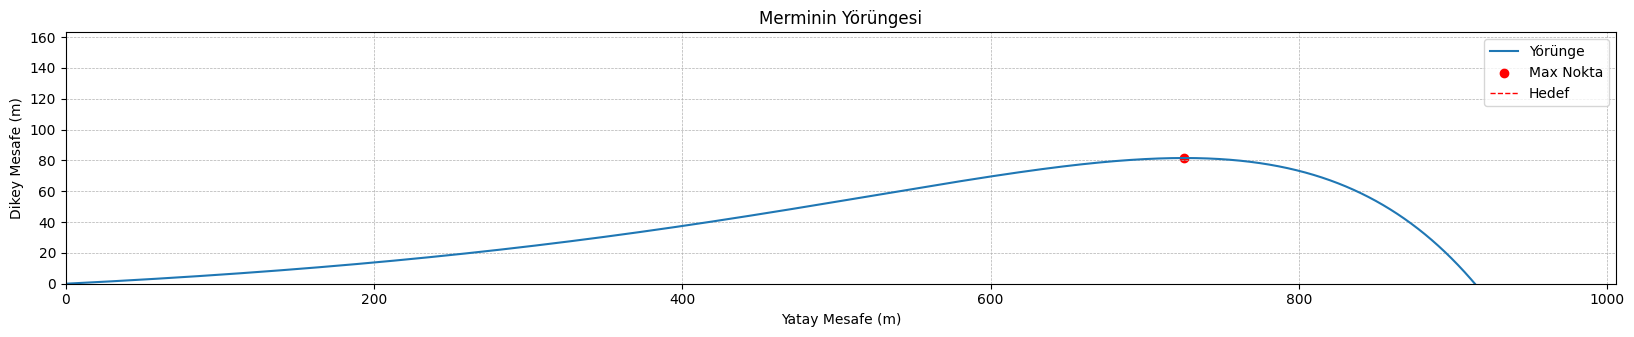

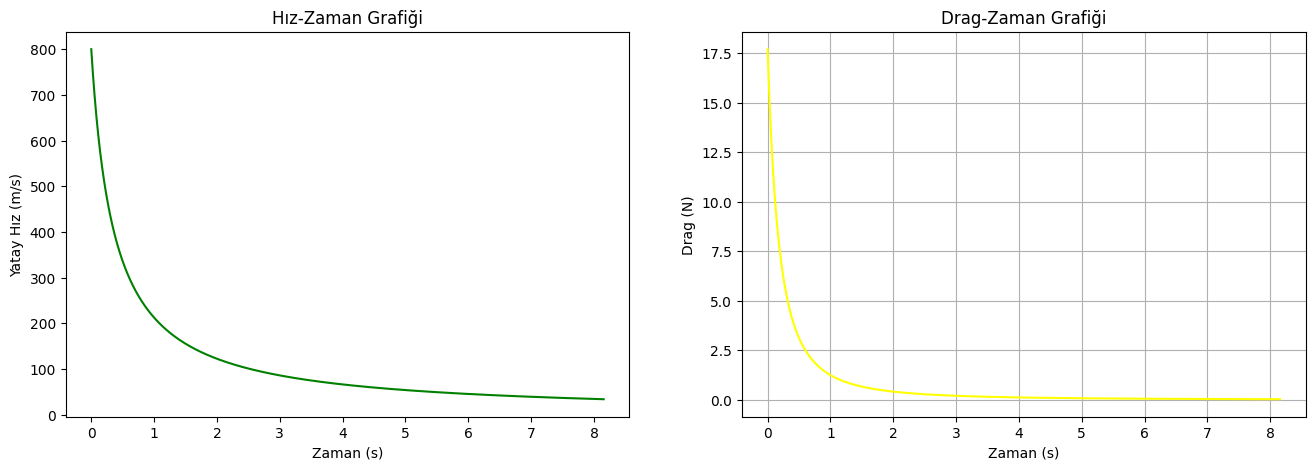

Mermi Adı: 5.56 NATO Mermisi
Hedef Adı: Çelik Hedefi
Mermi sivirilik: 0.8934000000000001
Yatay ilk hız: 800
Dikey ilk hız: -40
Sürüklenme katsayısı: 0.6995746586075665
Hava yoğunluğu: 1.1678108618060932

8.15 saniyede 1780.10 metre mesafede yere çakıldı.
Çarpma anında KE: 30.9952 J
Penetrasyon Derinliği: 0.0045 m
Deformasyon Çapı: 0.0000 m
Max Nokta: (1305.20, 81.55)


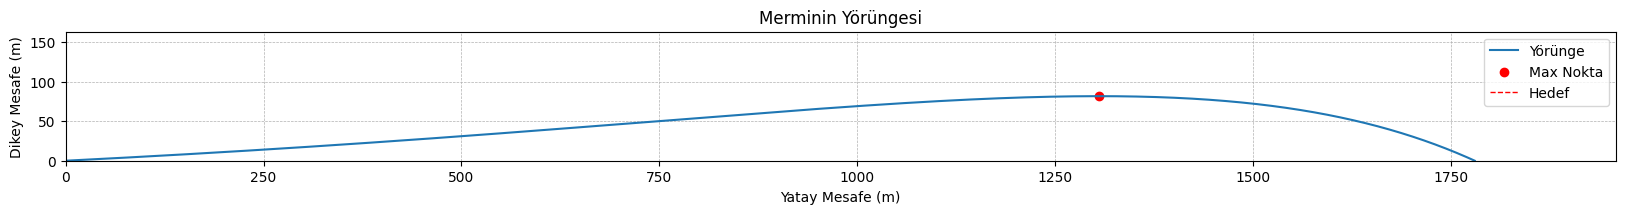

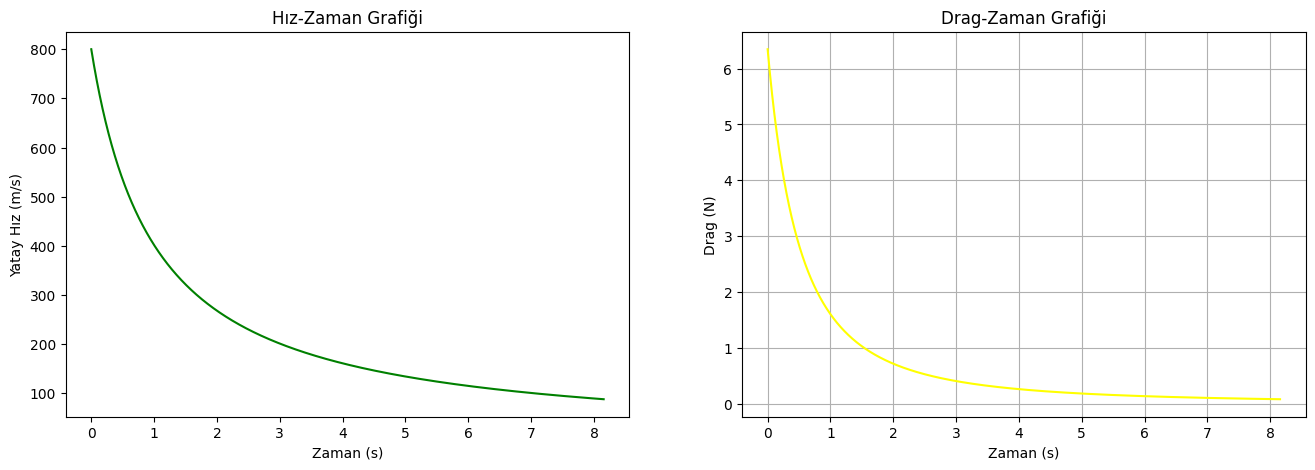

Mermi Adı: 7.62 NATO Mermisi
Hedef Adı: Çelik Hedefi
Mermi sivirilik: 0.937
Yatay ilk hız: 800
Dikey ilk hız: -40
Sürüklenme katsayısı: 0.6670224119530416
Hava yoğunluğu: 1.1678108618060932

8.15 saniyede 1398.40 metre mesafede yere çakıldı.
Çarpma anında KE: 18.5196 J
Penetrasyon Derinliği: 0.0015 m
Deformasyon Çapı: 0.0000 m
Max Nokta: (1060.50, 81.55)


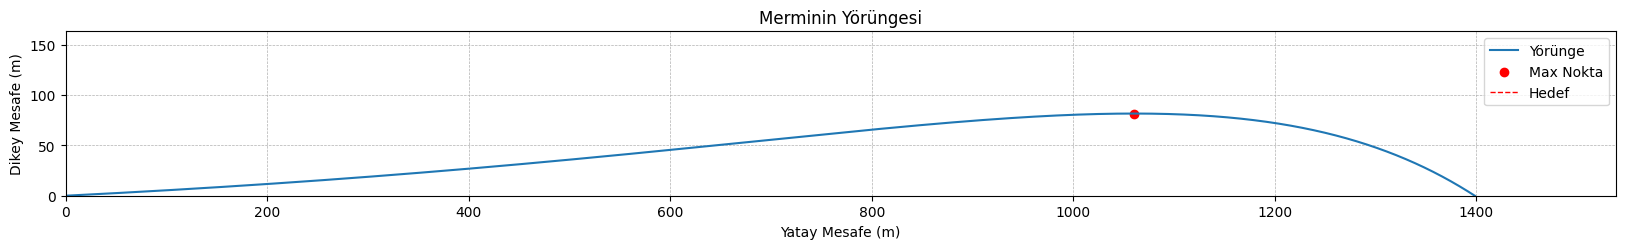

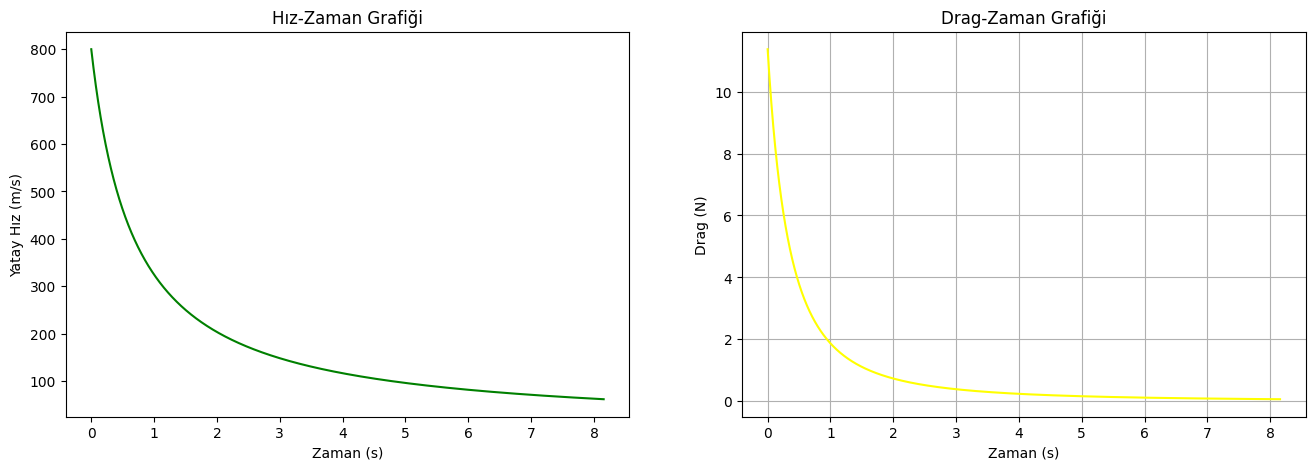

Mermi Adı: 155 mm Top Mermisi
Hedef Adı: Çelik Hedefi
Mermi sivirilik: 0.8565
Yatay ilk hız: 800
Dikey ilk hız: -40
Sürüklenme katsayısı: 0.7297139521307647
Hava yoğunluğu: 1.1678108618060932

Çarpma anında KE: 6513256.4990 J
Penetrasyon Derinliği: 1.1610 m
Deformasyon Çapı: 0.0357 m
Max Nokta: (2000.05, 76.18)


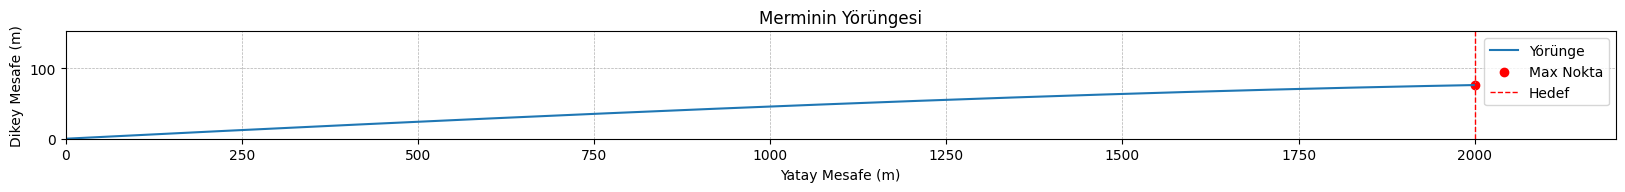

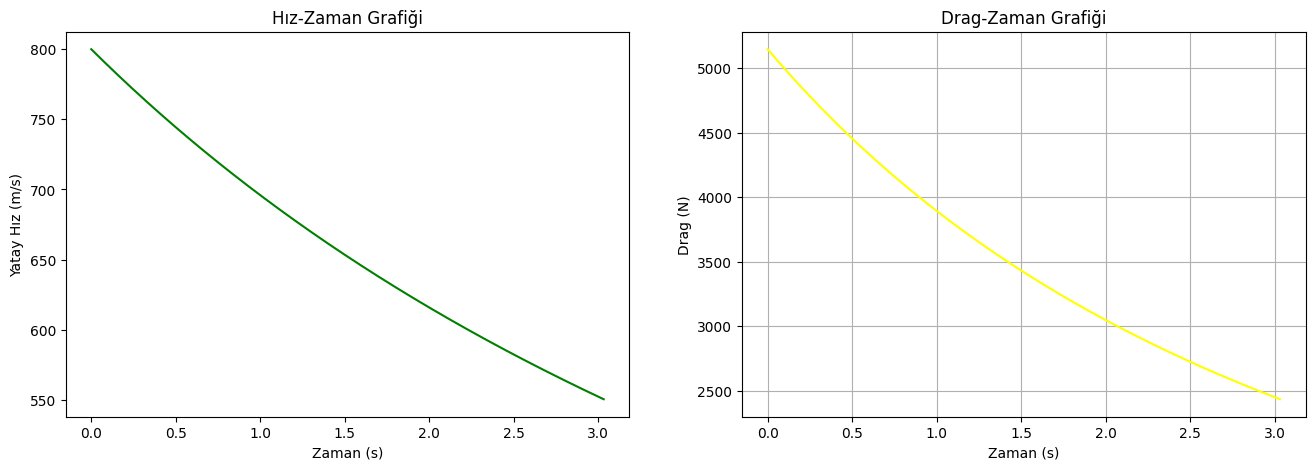

Mermi Adı: 12.7 mm (0.50 Cal BMG) Mermisi
Hedef Adı: Çelik Hedefi
Mermi sivirilik: 0.8481000000000001
Yatay ilk hız: 800
Dikey ilk hız: -40
Sürüklenme katsayısı: 0.7369413984199976
Hava yoğunluğu: 1.1678108618060932

8.15 saniyede 1920.11 metre mesafede yere çakıldı.
Çarpma anında KE: 243.1141 J
Penetrasyon Derinliği: 0.0064 m
Deformasyon Çapı: 0.0003 m
Max Nokta: (1390.95, 81.55)


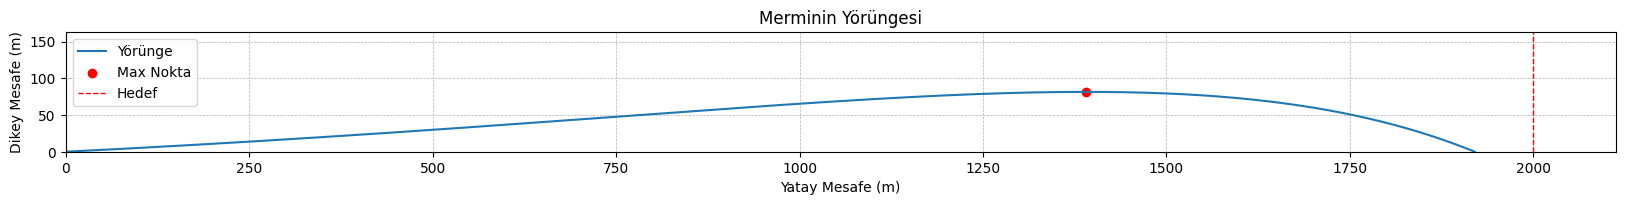

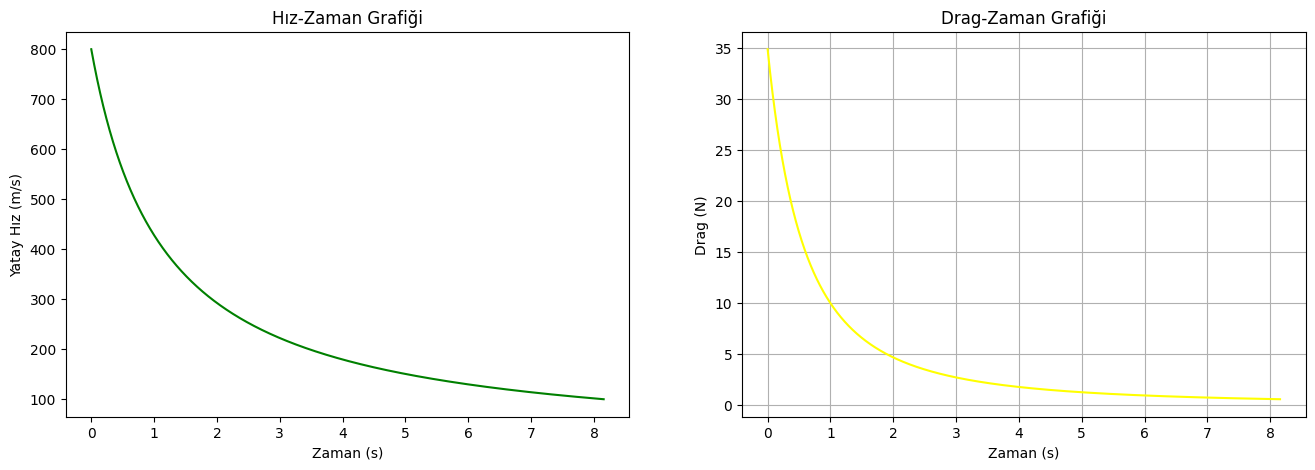

In [21]:
vx0, vy0 = 800,-40
full_simulation(mermi_9mm, celik_hedef,vx0, vy0, y=0, d=2000, delta_t=0.0001) # 9mm merminin genel başlangıc hızı 300m/s, Ağırlığının küçük olmasından dolayı enerjiyi çok fazla taşıyamayacaktır.
full_simulation(mermi_556, celik_hedef,vx0, vy0, y=0, d=2000, delta_t=0.0001)
full_simulation(mermi_762, celik_hedef,vx0, vy0, y=0, d=2000, delta_t=0.0001)
full_simulation(mermi_155mm, celik_hedef,vx0, vy0, y=0, d=2000, delta_t=0.0001)
full_simulation(mermi_50cal, celik_hedef,vx0, vy0, y=0, d=2000, delta_t=0.0001)

## Custom Deney

Mermi Adı: 155 mm Top Mermisi
Hedef Adı: Beton Hedefi
Mermi sivirilik: 0.8565
Yatay ilk hız: 1200
Dikey ilk hız: -30
Sürüklenme katsayısı: 0.7297139521307647
Hava yoğunluğu: 1.1701129034427247

Çarpma anında KE: 14626792.2811 J
Penetrasyon Derinliği: 26.0725 m
Deformasyon Çapı: 0.0778 m
Max Nokta: (2000.70, 90.61)


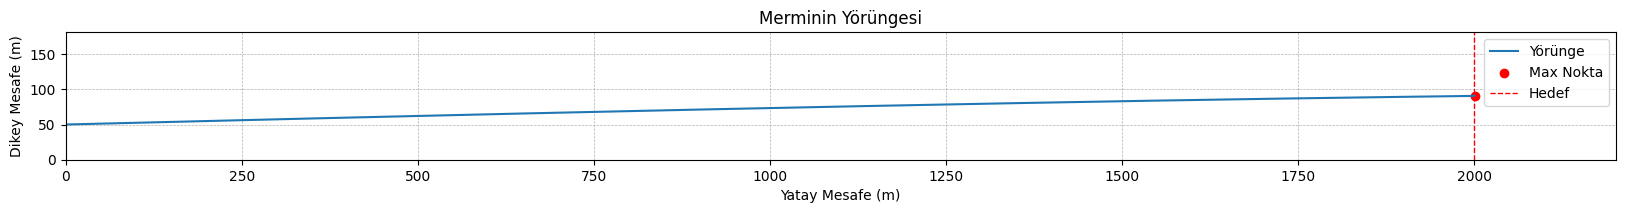

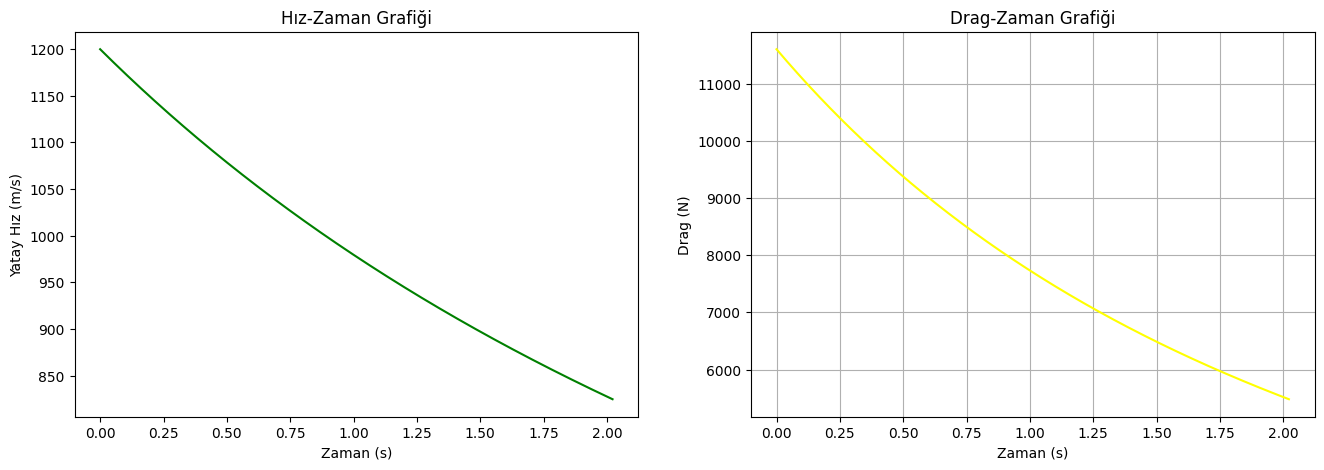

In [20]:
hedefler = [celik_hedef, aluminyum_hedef, tungsten_hedef, beton_hedef, kevlar_hedef]
mermiler = [mermi_9mm, mermi_556, mermi_762, mermi_155mm, mermi_50cal]

mermi = mermiler[3]         # mermi tipini ayarlayın
hedef = hedefler[3]         # hedefinizi seçin
vx0, vy0 = 1200,-30         # ilk hızları belirleyin
hedef_mesafesi = 2000       # Hedefin uzaklığını belirleyin
adim_araligi = 0.001        # Euler methodu için adım aralığını belirleyin
sicaklik_C = 25             # Hava sıcaklığını ayarlayın
nem = 60                    # Hava nem oranını ayarlayın Yüzdelik % cinsinden

full_simulation(
    mermi=mermi,
    hedef=hedef,
    vx0=vx0,
    vy0=vy0,
    delta_t=adim_araligi,
    d=hedef_mesafesi,
    temp=sicaklik_C,
    RH=nem
)